## Import required libraries

In [ ]:
!pip install git+https://github.com/SalesforceAIResearch/uni2ts.git numpy scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4 utils==1.0.2

  Cloning https://github.com/SalesforceAIResearch/uni2ts.git to /tmp/pip-req-build-uzcai_b6
  Running command git clone --filter=blob:none --quiet https://github.com/SalesforceAIResearch/uni2ts.git /tmp/pip-req-build-uzcai_b6
  Resolved https://github.com/SalesforceAIResearch/uni2ts.git to commit c5618a5817a22a9cfad01f782f22f5f8242dce05
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached utils-1.0.2.tar.gz (13 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13905 sha256=ef37c258f08450c13b63c1136e5be5410a465a09bd2d7470e6a8f003d1752e9a
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


Import required modules

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from einops import rearrange
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

Create calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Load AirPassengersDataset and dispaly the dataframe

In [ ]:
# Load dataframe and plot it
# To load local csv  > modify to the right path where the file is present
df = pd.read_csv('AirPassengersDataset.csv')
df.rename(columns={'y': 'target'}, inplace=True)
df.drop(columns=['unique_id'], inplace=True)
df["ds"] = pd.to_datetime(df["ds"])
df.set_index("ds", inplace=True)
print(f"total length: {df.shape[0]}")
print(f"time frequency: {df.index.diff()[1]}")

total length: 144
time frequency: 28 days 00:00:00


In [ ]:
df

,target
ds,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1960-08-31,606
1960-09-30,508
1960-10-31,461


Create a sample for the hourly data

In [ ]:
inp = {
    "target": df["target"].to_numpy()[:120],
    "start": df.index[0].to_period(freq="M"),
}
label = {
    "target": df["target"].to_numpy()[120:144],
    "start": df.index[120].to_period(freq="M"),
}

In [ ]:
inp

{'target': array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
        126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
        178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
        181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
        229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
        264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
        364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
        405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467,
        404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404,
        359, 310, 337]),
 'start': Period('1949-01', 'M')}

In [ ]:
label

{'target': array([360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405, 417,
        391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432]),
 'start': Period('1959-01', 'M')}

Let's initialize, train the model and define its hyperparameters

In [ ]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
    prediction_length=24,
    context_length=120,
    patch_size=32,
  num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

# Time series values. Shape: (batch, time, variate)
past_target = rearrange(
    torch.as_tensor(inp["target"], dtype=torch.float32), "t -> 1 t 1"
)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)

Calculate the error metrics

In [ ]:
calculate_error_metrics(label["target"],np.round(np.median(forecast[0], axis=0), decimals=4))

MSE : 5319.221497305669
RMSE : 72.93299320133289
MAPE : 0.10728392512332686
r2 : 0.04616826793581874
adjusted_r2 : 0.0028122801147195675


Let's predict

In [ ]:
print(
    "median prediction:\n",
    np.round(np.median(forecast[0], axis=0), decimals=4),
)
print("ground truth:\n", label["target"])

median prediction:
 [379.8565 386.5126 390.0413 398.3502 403.2256 405.6777 406.6938 417.8278
 397.7138 394.6458 414.2654 406.3108 404.5158 421.6768 425.0043 417.1104
 443.4794 433.2636 458.7923 447.1753 460.982  429.9554 452.9716 423.3293]
ground truth:
 [360 342 406 396 420 472 548 559 463 407 362 405 417 391 419 461 472 535
 622 606 508 461 390 432]


Visualize the predictions

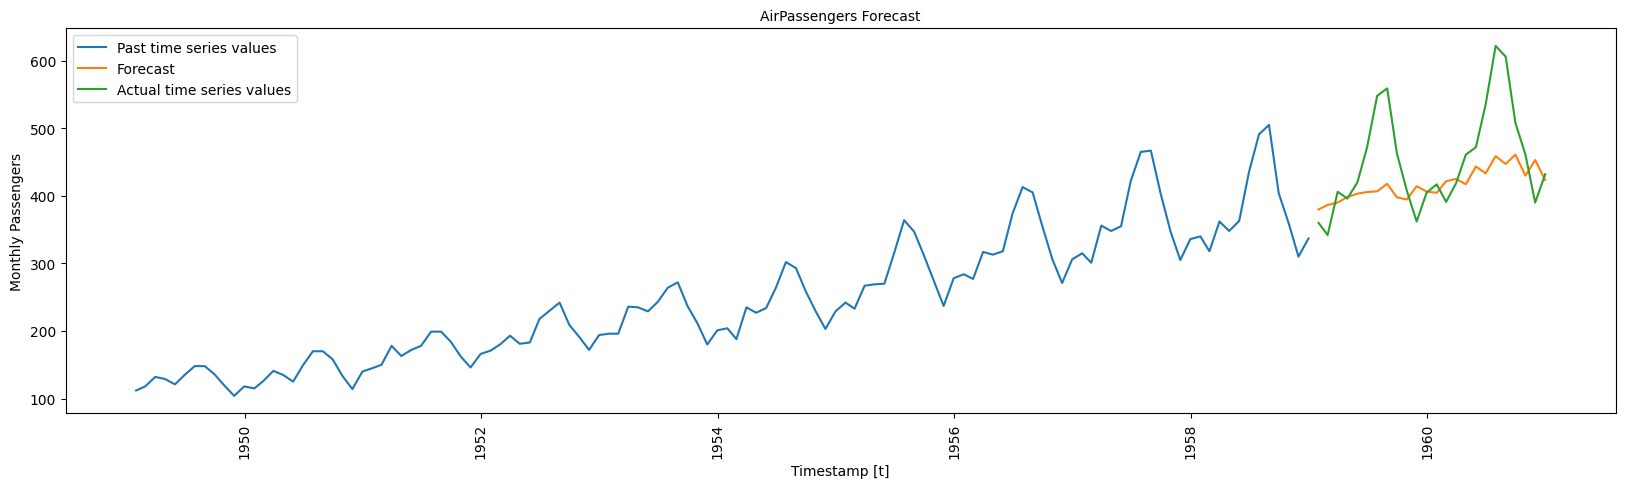

In [ ]:
df_test = df["target"][120:144]
df_train = df["target"][:120]
df_test = df_test.reset_index().rename(columns={"index":"ds"})
df_train = df_train.reset_index().rename(columns={"index":"ds"})
df_test['Predicted']= pd.Series(np.round(np.median(forecast[0], axis=0), decimals=4))
df_train.set_index('ds',inplace =True)
df_test.set_index('ds',inplace =True)
plt.figure(figsize=(20, 5))
y_past = df_train["target"]
y_pred = df_test['Predicted']
y_test = df_test["target"]
plt.plot(y_past, label="Past time series values")
plt.plot(y_pred, label="Forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)
#plt.tight_layout()
plt.xticks(rotation=90)
plt.legend();